# Morphological Filters in Julia

In [1]:
using Images
using IJulia
using Interpolations
function resize(img)
    imresize(img, (300, 300), method=Interpolations.Constant())
end

resize (generic function with 1 method)

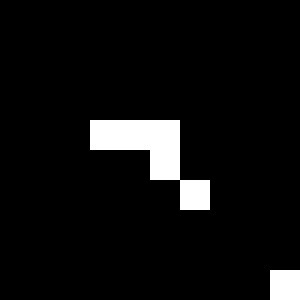

In [2]:
img1 = Gray.(zeros(10, 10))
img1[5, 5] = 1.0
img1[5, 4] = 1.0
img1[5, 6] = 1.0
img1[6, 6] = 1.0
img1[7, 7] = 1.0
img1[10, 10] = 1.0
resize(img1)

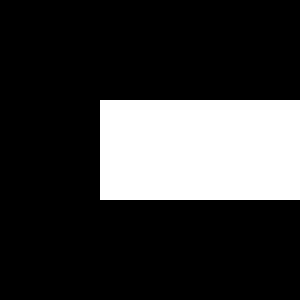

In [3]:
kernel1 = Gray.([0.0 0.0 0.0; 0.0 1.0 1.0; 0.0 0.0 0.0])
resize(kernel1)


In [30]:

# Dilution Function
function dilution_binary(image::Matrix{Gray{Float64}}, kernel::Matrix{Gray{Float64}})
    y_kernel_dim, x_kernel_dim = size(kernel) # eg. 3,3
    focus_y, focus_x = ceil(Int, y_kernel_dim / 2), ceil(Int, x_kernel_dim / 2) # eg. 2,2
    height, width = size(image) # eg. 10,10
    result_image = Gray.(zeros(height + y_kernel_dim - 1, width + x_kernel_dim - 1)) #eg. 12,12
    for j in 1:y_kernel_dim
        for i in 1:x_kernel_dim
            if kernel[j, i] == 1.0
                # the kernel pixel is active
                offset_y, offset_x = j - focus_y, i - focus_x
                for y in 1:height
                    for x in 1:width
                        if image[y, x] == 1.0
                            result_image[y+offset_y+focus_y-1, x+offset_x+focus_x-1] = 1.0
                        end
                    end
                end
            end
        end
    end
    return result_image[2:end-1, 2:end-1]
end

dilution_binary (generic function with 1 method)

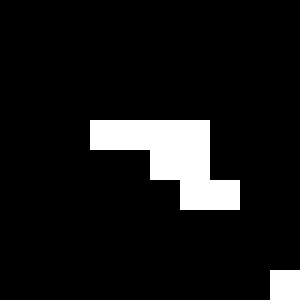

In [5]:
resize(dilution_binary(img1, kernel1))

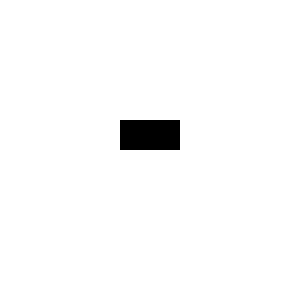

In [31]:
invert(image::Matrix{Gray{Float64}}) = image .* -1 .+ 1

function erosion_binary(image::Matrix{Gray{Float64}}, kernel::Matrix{Gray{Float64}})
    invert(dilution_binary(invert(image), kernel))
end

resize(dilution_binary(invert(img1), kernel1))


In [32]:

# Dilution Function for continuous images.
# Here in the kernel values of 99 are ignored
function dilution_continuous(image::Matrix{Gray{Float64}}, kernel::Matrix{Gray{Float64}})
    y_kernel_dim, x_kernel_dim = size(kernel) # eg. 3,3
    focus_y, focus_x = ceil(Int, y_kernel_dim / 2), ceil(Int, x_kernel_dim / 2) # eg. 2,2
    height, width = size(image) # eg. 10,10
    result_image = Gray.(zeros(height + y_kernel_dim - 1, width + x_kernel_dim - 1)) #eg. 12,12
    for j in 1:y_kernel_dim
        for i in 1:x_kernel_dim
            if kernel[j, i] != 99.0
                # the kernel pixel is active
                offset_y, offset_x = j - focus_y, i - focus_x
                for y in 1:height
                    for x in 1:width
                        prev_cell = result_image[y+offset_y+focus_y-1, x+offset_x+focus_x-1]
                        maybe_next_cell = kernel[j, i] * image[y, x]
                        if maybe_next_cell > prev_cell
                            result_image[y+offset_y+focus_y-1, x+offset_x+focus_x-1] = maybe_next_cell
                        end
                    end
                end
            end


        end
    end
    return result_image[2:end-1, 2:end-1]
end


function erosion_continuous(image::Matrix{Gray{Float64}}, kernel::Matrix{Gray{Float64}})
    invert(dilution_continuous(invert(image), kernel))
end

erosion_continuous (generic function with 1 method)

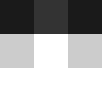

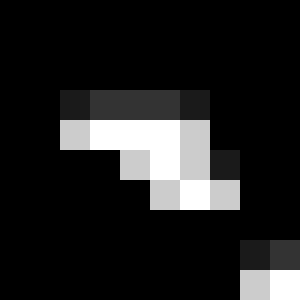

In [8]:
kernel_c = Gray.([
    0.1 0.2 0.1
    0.8 1.0 0.8
    99.0 99.0 99.0])
IJulia.display(kernel_c)
resize(dilution_continuous(img1, kernel_c))

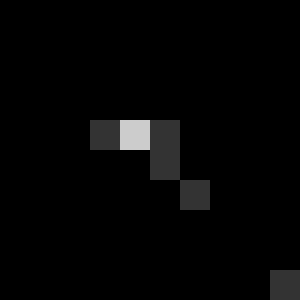

In [9]:
resize(erosion_continuous(img1, kernel_c))

# trying some nicer images and kernels

input images

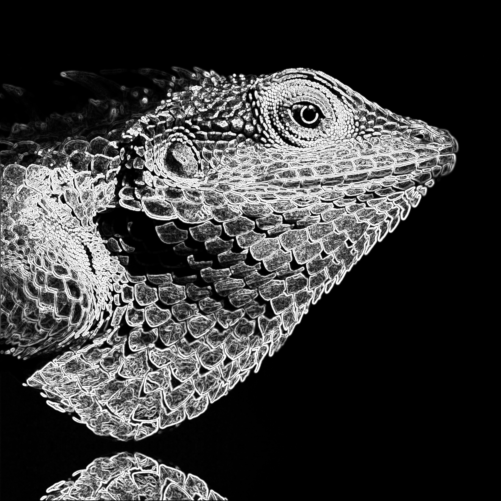

lizard image has shape: (4000, 4000)robot image has shape: (500, 700)

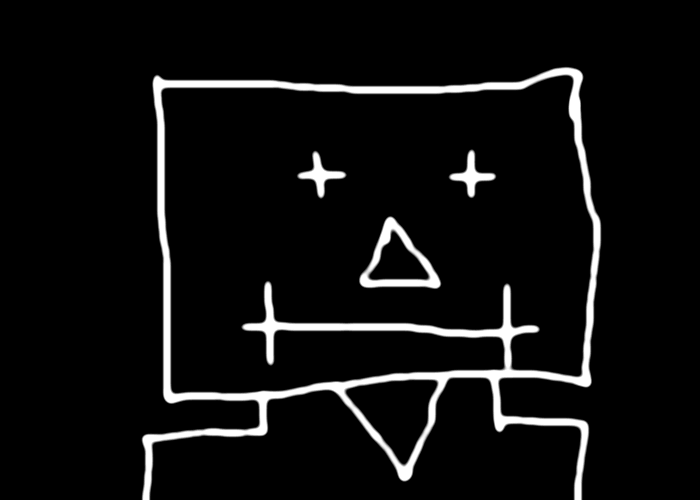

In [10]:
img_lizard = Gray{Float64}.(load("./images/input/lizard_sobel_4000.jpg"))
print("lizard image has shape: $(size(img_lizard))")
IJulia.display(img_lizard)
img_robot = Gray{Float64}.(load("./images/input/robot.png"))
print("robot image has shape: $(size(img_robot))")
IJulia.display(img_robot)

load some interesting kernels

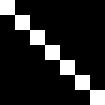

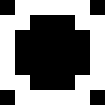

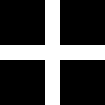

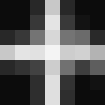

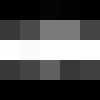

In [11]:
kernels = map(1:5) do x 
    Gray{Float64}.(load("./images/input/kernel$(x).png"))
end

for k in kernels
    IJulia.display(k)
end

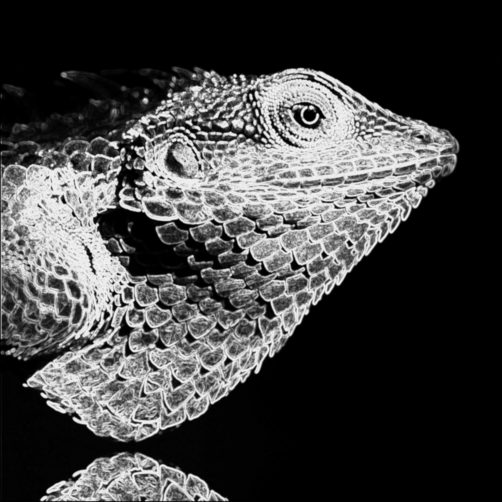

In [12]:
dilution_continuous(img_lizard, kernels[4])

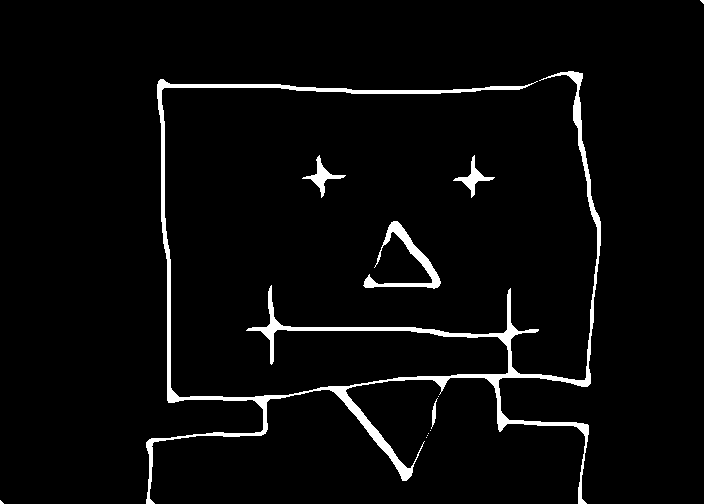

In [13]:
erosion_binary(img_robot, kernels[1])

2x erosion on these areas

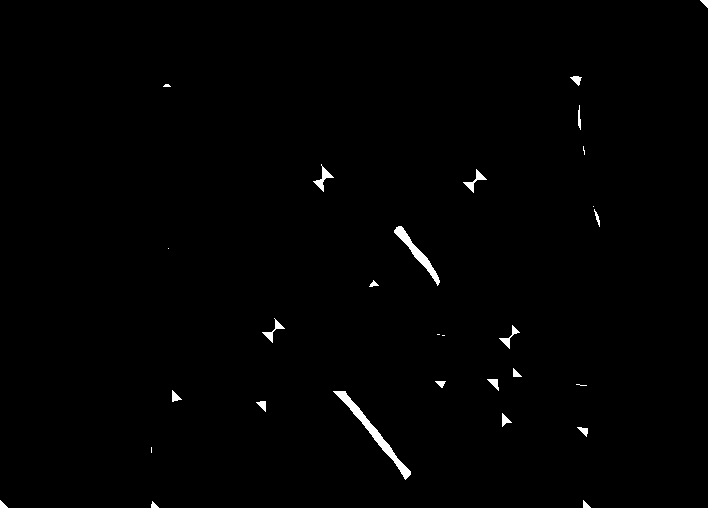

In [14]:
erosion_binary(erosion_binary(img_robot, kernels[1]), kernels[1])

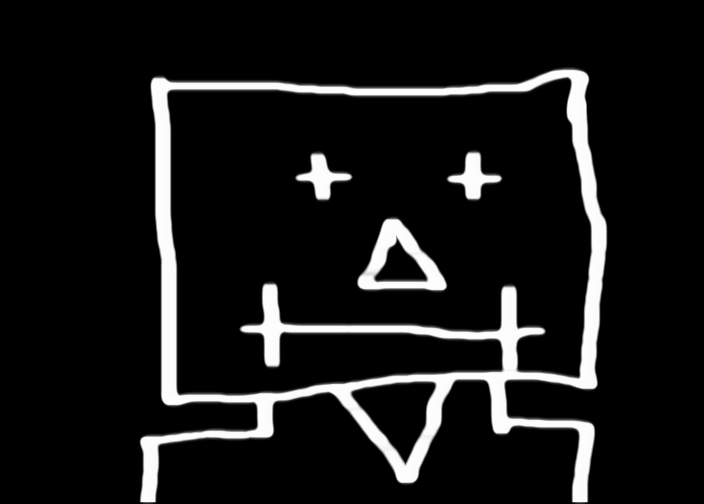

In [15]:
dilution_continuous(dilution_continuous(img_robot, kernels[5]), kernels[5])

use the cross shaped filter to find corners:

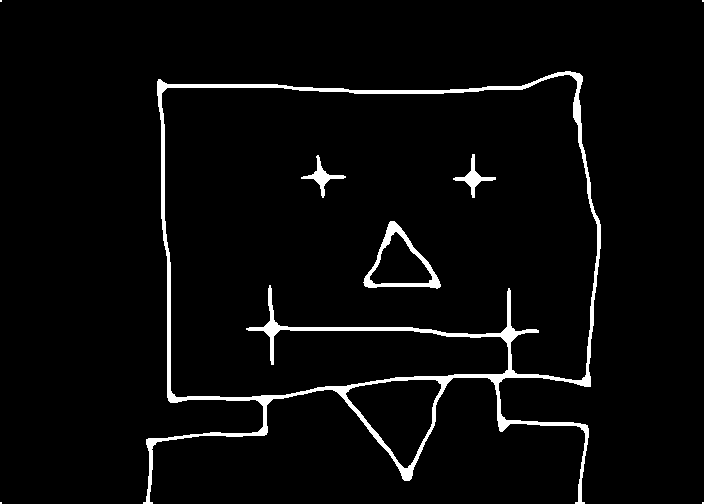

In [16]:
erosion_binary(img_robot, kernels[3])

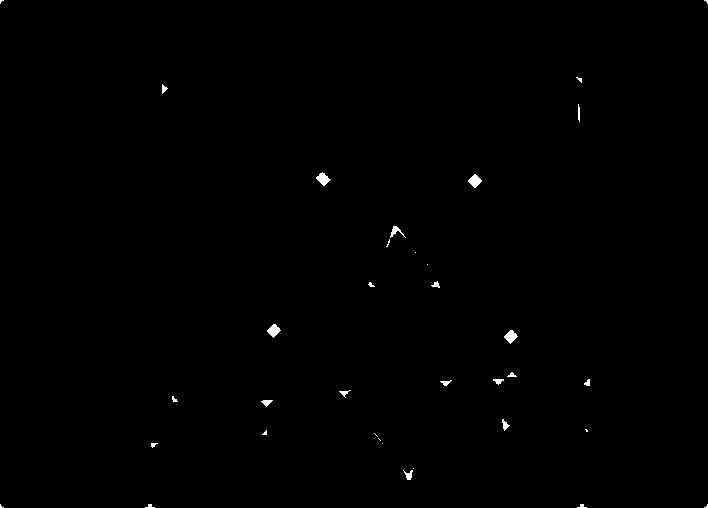

In [17]:
erosion_binary(erosion_binary(img_robot, kernels[3]), kernels[3])

# Runtime Analysis

3x3 filter:

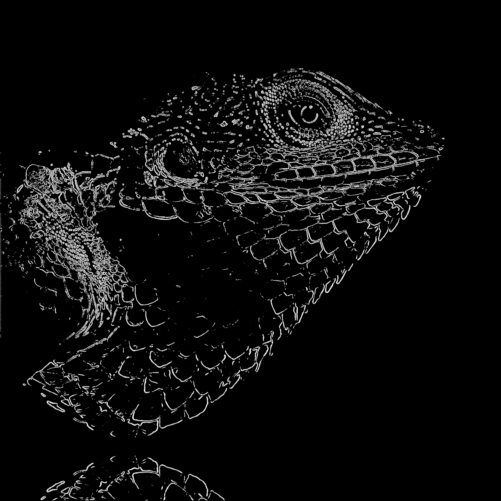

  0.593144 seconds (6 allocations: 366.455 MiB)



binary 3x3 kernel with 2 active points

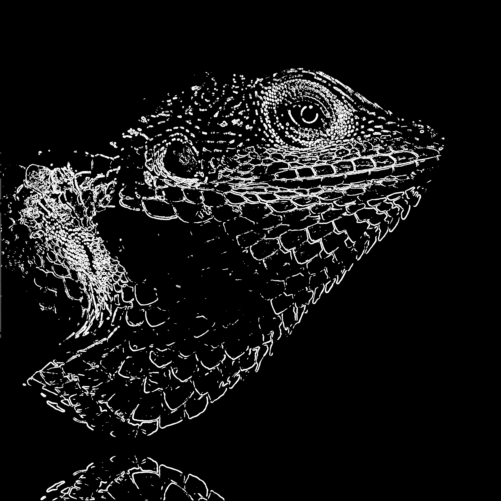


  2.115488 seconds (6 allocations: 366.455 MiB)



binary 3x3 kernel with 9 active points


In [21]:
kernel1 = Gray.([0.0 0.0 0.0; 0.0 1.0 1.0; 0.0 0.0 0.0])

@time i = dilution_binary(img_lizard, kernel1)
IJulia.display(i)
println("\nbinary 3x3 kernel with 2 active points")

kernel2 = Gray.(ones((3,3)))

@time i = dilution_binary(img_lizard, kernel2)
IJulia.display(i)
println("\nbinary 3x3 kernel with 9 active points")

continous dilution 3x3 kernel with 2 active points

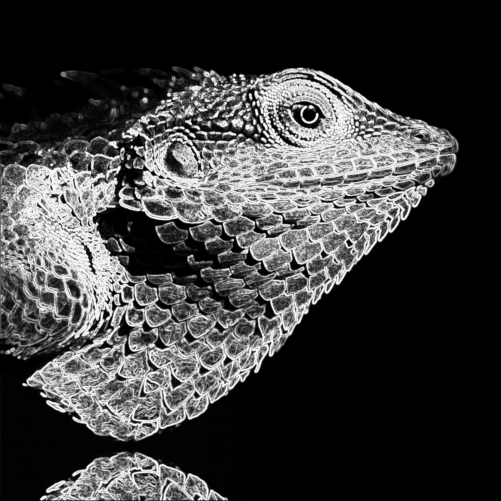


  2.436381 seconds (6 allocations: 366.455 MiB, 7.90% gc time)
continous  dilution 3x3 kernel with 9 active points


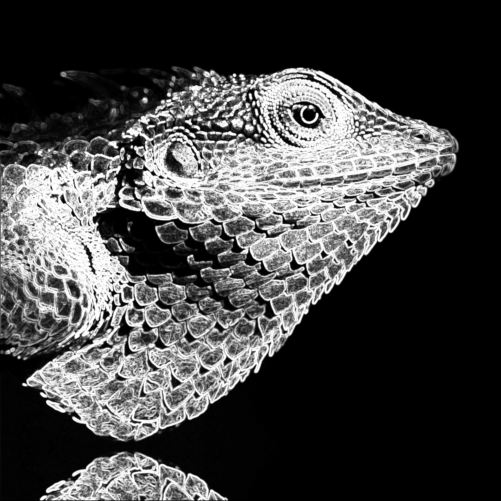

  2.226303 seconds (6 allocations: 366.455 MiB, 1.08% gc time)
continous erosion 3x3 kernel with 2 active points


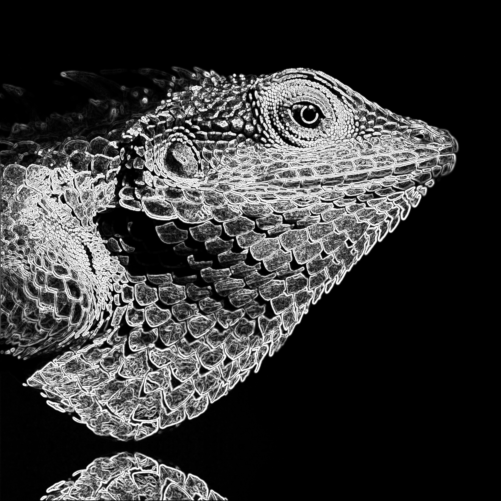

  2.393560 seconds (10 allocations: 610.596 MiB, 2.14% gc time)
continous erosion 3x3 kernel with 9 active points

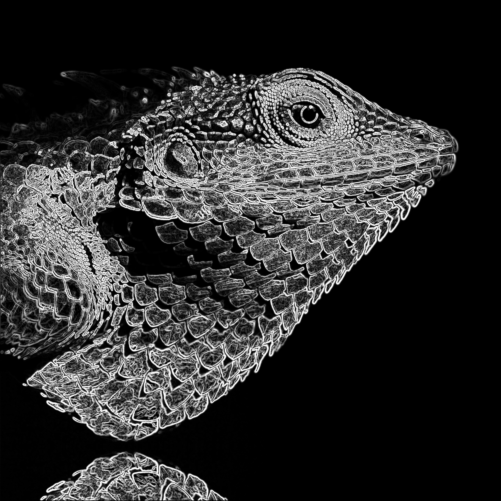


  2.554700 seconds (10 allocations: 610.596 MiB, 1.74% gc time)


In [19]:
println("continuous dilution 3x3 kernel with 2 active points")
@time i = dilution_continuous(img_lizard, kernel1)
IJulia.display(i)

println("continuous  dilution 3x3 kernel with 9 active points")
@time i = dilution_continuous(img_lizard, kernel2)
IJulia.display(i)

println("continuous erosion 3x3 kernel with 2 active points")
@time i = erosion_continuous(img_lizard, kernel1)
IJulia.display(i)

println("continuous erosion 3x3 kernel with 9 active points")
@time i = erosion_continuous(img_lizard, kernel2)
IJulia.display(i)

effect of kernel size

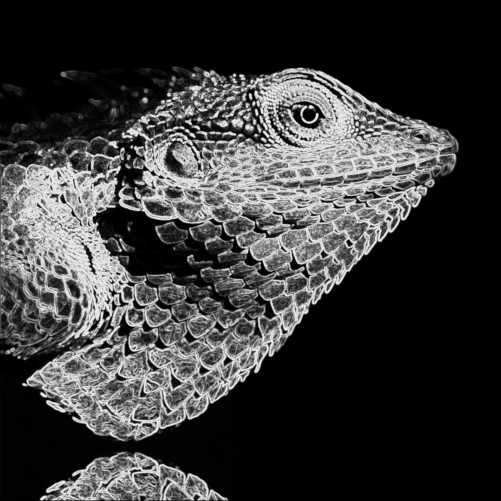

  3.865078 seconds (6 allocations: 366.455 MiB, 1.30% gc time)

random 3x3 kernel

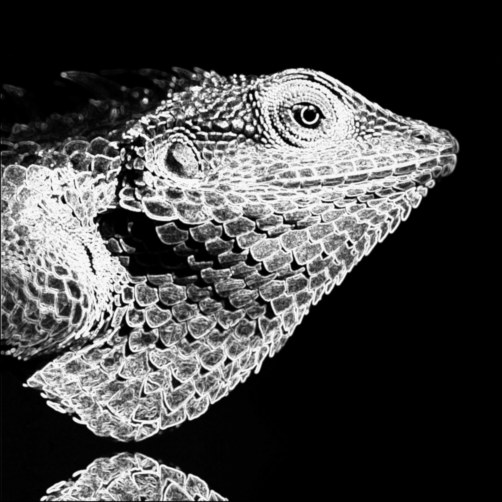


  8.136037 seconds (6 allocations: 366.822 MiB, 0.20% gc time)

random 5x5 kernel

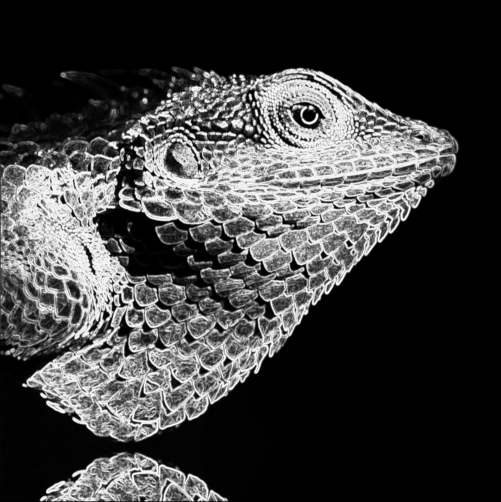


  5.275202 seconds (6 allocations: 367.005 MiB, 0.58% gc time)

random 10x2 kernel


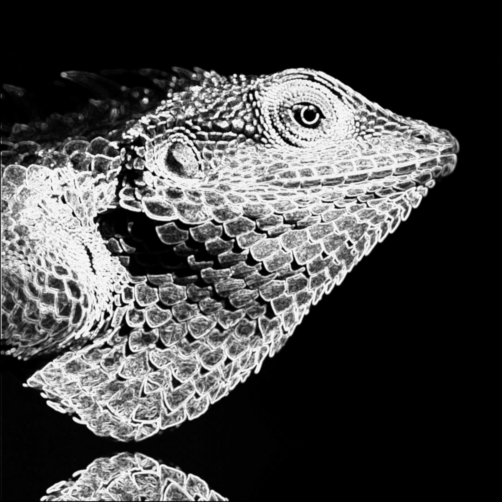

 12.386467 seconds (6 allocations: 367.188 MiB, 0.11% gc time)

random 7x7 kernel


4-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing

In [29]:
map([(3,3), (5,5), (10,2), (7,7)]) do (x,y)
    kernel = Gray.(rand(x,y))
   
    @time i = dilution_continuous(img_lizard, kernel)
    println("\nrandom $(x)x$(y) kernel")
    # IJulia.display(i)
end

# Opening and Closing

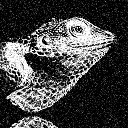

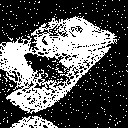

In [35]:
liz_c = Gray{Float64}.(load("./images/input/lizard_noise_small.jpg"))
IJulia.display(liz_c)
liz_b = Gray{Float64}.(load("./images/input/lizard_noise_small_binary.jpg"))

In [40]:
function opening_binary(image::Matrix{Gray{Float64}}, kernel::Matrix{Gray{Float64}})
    dilution_binary(erosion_binary(image, kernel),kernel)
end

function closing_binary(image::Matrix{Gray{Float64}}, kernel::Matrix{Gray{Float64}})
    erosion_binary(dilution_binary(image, kernel),kernel)
end

function opening_continuous(image::Matrix{Gray{Float64}}, kernel::Matrix{Gray{Float64}})
    dilution_continuous(erosion_continuous(image, kernel),kernel)
end

function closing_continuous(image::Matrix{Gray{Float64}}, kernel::Matrix{Gray{Float64}})
    erosion_continuous(dilution_continuous(image, kernel),kernel)
end

closing_continuous (generic function with 1 method)

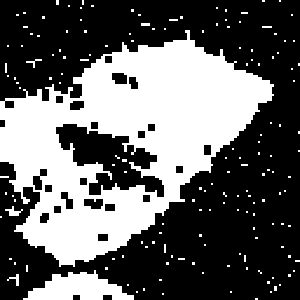

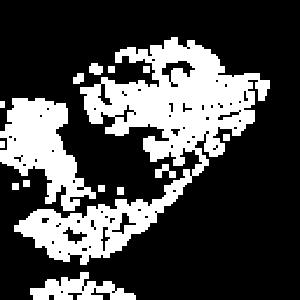

In [46]:
kernel = Gray.(ones((3,3)))
IJulia.display(resize(closing_binary(liz_b, kernel)))
IJulia.display(resize(opening_binary(liz_b, kernel)))

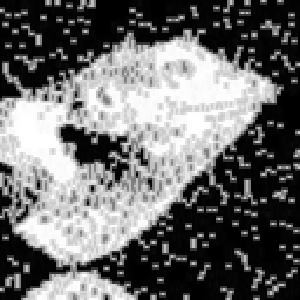

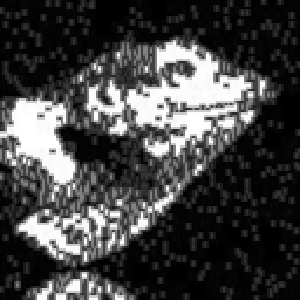

In [48]:
kernel = Gray.([0.5 0.8 0.5; 0.5 1.0 0.5; 0.5 0.8 0.5])
IJulia.display(resize(closing_continuous(liz_b, kernel)))
IJulia.display(resize(opening_continuous(liz_b, kernel)))

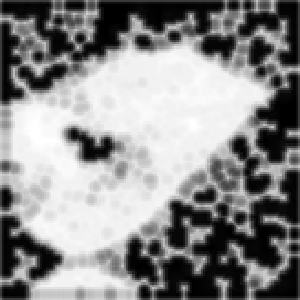

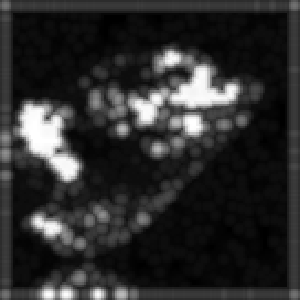

In [65]:
kernel = map(enumerate(ones(7,7))) do x
    (i,_) = x
    x = (i-1)÷7 -3
    y = (i-1)%7 -3
    Gray((18 - x^2 - y^2) / 18)
end

IJulia.display(resize(closing_continuous(liz_b, kernel)))
IJulia.display(resize(opening_continuous(liz_b, kernel)))